# Multi-label Legal Text Classification for CIA

## Models and Experiments: Pre-Trained Embeddings

In [ ]:
!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

In [22]:
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import umap.umap_ as umap
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, classification_report, confusion_matrix

In [4]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

### Preliminaries

Load data

In [52]:
text = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)
text_labels = pd.read_csv("data/01 legal_texts_with_labels_grouped.csv", index_col=0)
defs = pd.read_csv("data/02 oecd_definitions_stopwords.csv", index_col=0)
defs_grouped = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

In [15]:
defs_grouped

,Main,text_clean,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,D,regul sometim limit choic avail to consum for ...,257


Clean labels

In [16]:
text_labels.Category.value_counts()

A       765
None    663
B        89
C        15
D         1
Name: Category, dtype: int64

### I. GloVe

##### Document embedding matrix

In [17]:
# load GloVe embeddings
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

(400000, 300)

In [18]:
# function for doc embeddings
def doc_embed(df, vectorizer):
    dfm = vectorizer.fit_transform(df['text_clean'])
    common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])
    return matrix

In [19]:
vectorizer = TfidfVectorizer()

In [21]:
# doc embeddings for legal text
text_labels_embed = doc_embed(text_labels, vectorizer)
text_labels_embed.shape

<ipython-input-18-a1551b9937a4>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(1533, 300)

In [24]:
# doc embeddings for grouped labels
defs_grouped_embed = doc_embed(defs_grouped, vectorizer)
defs_grouped_embed.shape

<ipython-input-18-a1551b9937a4>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(4, 300)

##### Cosine similarities

In [25]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [26]:
docs = []
for i in range(len(text_labels_embed)):
    scores = []
    for j in range(len(defs_grouped_embed)):
        A = text_labels_embed[i]
        B = defs_grouped_embed[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [27]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "D"])

In [28]:
scores_df

,A,B,C,D
0,0.900639,0.891333,0.893115,0.898040
1,0.927538,0.921590,0.915604,0.913527
2,0.970012,0.964144,0.958430,0.957851
3,0.973165,0.971365,0.966159,0.967711
4,0.973165,0.971365,0.966159,0.967711
...,...,...,...,...
1528,0.910013,0.905642,0.910329,0.900373
1529,0.868029,0.862512,0.862505,0.851599
1530,0.806016,0.799959,0.801712,0.789647
1531,0.811392,0.808621,0.807262,0.811037


In [29]:
# df with scores
text_scores_labels_glove = pd.merge(text_labels, scores_df, left_index=True, right_index=True)

In [30]:
text_scores_labels_glove.to_csv("data/scores/01 sim_scores_glove_labeled.csv")

##### Threshold test

In [10]:
text_scores_labels_glove = pd.read_csv("data/scores/01 sim_scores_glove_labeled.csv", index_col=0)

In [11]:
text_scores_labels_glove

,Unnamed: 0,Law,Paragraph,Text,Category,text_clean,A,B,C,D
0,0,Resolution 153/2010 by National Civil Aviation...,"Art. 5, sole par",If any competent body on the matter imposes mo...,A,if ani compet bodi on the matter impos modif o...,0.900639,0.891333,0.893115,0.898040
2,2,Ministerial Ordinance 93/2020 by Ministry of I...,Art.4,The National Civil Aviation Secretary must aut...,A,the nation civil aviat secretari must authoris...,0.970012,0.964144,0.958430,0.957851
3,3,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 6,The commercial contract which involves the use...,A,the commerci contract which involv the use of ...,0.973165,0.971365,0.966159,0.967711
4,4,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,0.973165,0.971365,0.966159,0.967711
5,5,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,0.922596,0.912327,0.910772,0.917047
...,...,...,...,...,...,...,...,...,...,...
1528,1528,Resolution 440/2017 by National Civil Aviation...,Art. 3,The procedures for registration and the calend...,None,the procedur for registr and the calendar of a...,0.910013,0.905642,0.910329,0.900373
1529,1529,Resolution 440/2017 by National Civil Aviation...,Art. 3 sole par,"ANAC, by means of an ordinance, may exempt non...",None,anac by mean of an ordin may exempt non-regula...,0.868029,0.862512,0.862505,0.851599
1530,1530,Resolution 440/2017 by National Civil Aviation...,Art. 4,The flight stage may only be registered with A...,None,the flight stage may onli be regist with anac ...,0.806016,0.799959,0.801712,0.789647
1531,1531,Resolution 440/2017 by National Civil Aviation...,Art. 4 par 2,The offer of regular air transport services de...,None,the offer of regular air transport servic depe...,0.811392,0.808621,0.807262,0.811037


In [14]:
df_long = pd.melt(text_scores_labels_glove, id_vars=['Unnamed: 0', 'Law', 'Paragraph', 'Text', 'Category', 'text_clean'], var_name='Predict_Label', value_name='Score')

In [15]:
df_long

,Unnamed: 0,Law,Paragraph,Text,Category,text_clean,Predict_Label,Score
0,0,Resolution 153/2010 by National Civil Aviation...,"Art. 5, sole par",If any competent body on the matter imposes mo...,A,if ani compet bodi on the matter impos modif o...,A,0.900639
1,2,Ministerial Ordinance 93/2020 by Ministry of I...,Art.4,The National Civil Aviation Secretary must aut...,A,the nation civil aviat secretari must authoris...,A,0.970012
2,3,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 6,The commercial contract which involves the use...,A,the commerci contract which involv the use of ...,A,0.973165
3,4,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,A,0.973165
4,5,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,A,0.922596
...,...,...,...,...,...,...,...,...
5971,1528,Resolution 440/2017 by National Civil Aviation...,Art. 3,The procedures for registration and the calend...,None,the procedur for registr and the calendar of a...,D,0.900373
5972,1529,Resolution 440/2017 by National Civil Aviation...,Art. 3 sole par,"ANAC, by means of an ordinance, may exempt non...",None,anac by mean of an ordin may exempt non-regula...,D,0.851599
5973,1530,Resolution 440/2017 by National Civil Aviation...,Art. 4,The flight stage may only be registered with A...,None,the flight stage may onli be regist with anac ...,D,0.789647
5974,1531,Resolution 440/2017 by National Civil Aviation...,Art. 4 par 2,The offer of regular air transport services de...,None,the offer of regular air transport servic depe...,D,0.811037


In [30]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.90, results_multiclass['Predict_Label'], 'None')

In [31]:
results_multiclass.drop_duplicates()

,Unnamed: 0,Law,Paragraph,Text,Category,text_clean,Predict_Label,Score,Predict
0,0,Resolution 153/2010 by National Civil Aviation...,"Art. 5, sole par",If any competent body on the matter imposes mo...,A,if ani compet bodi on the matter impos modif o...,A,0.900639,A
1,2,Ministerial Ordinance 93/2020 by Ministry of I...,Art.4,The National Civil Aviation Secretary must aut...,A,the nation civil aviat secretari must authoris...,A,0.970012,A
2,3,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 6,The commercial contract which involves the use...,A,the commerci contract which involv the use of ...,A,0.973165,A
3,4,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,A,0.973165,A
4,5,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,The National Civil Aviation Secretary may auth...,A,the nation civil aviat secretari may authoris ...,A,0.922596,A
...,...,...,...,...,...,...,...,...,...
5971,1528,Resolution 440/2017 by National Civil Aviation...,Art. 3,The procedures for registration and the calend...,None,the procedur for registr and the calendar of a...,D,0.900373,D
5972,1529,Resolution 440/2017 by National Civil Aviation...,Art. 3 sole par,"ANAC, by means of an ordinance, may exempt non...",None,anac by mean of an ordin may exempt non-regula...,D,0.851599,None
5973,1530,Resolution 440/2017 by National Civil Aviation...,Art. 4,The flight stage may only be registered with A...,None,the flight stage may onli be regist with anac ...,D,0.789647,None
5974,1531,Resolution 440/2017 by National Civil Aviation...,Art. 4 par 2,The offer of regular air transport services de...,None,the offer of regular air transport servic depe...,D,0.811037,None


In [32]:
report = classification_report(results_multiclass['Category'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.50      0.18      0.26      3048
           B       0.06      0.17      0.09       356
           C       0.01      0.16      0.01        44
           D       0.00      0.25      0.00         4
        None       0.42      0.31      0.36      2524

    accuracy                           0.23      5976
   macro avg       0.20      0.21      0.15      5976
weighted avg       0.44      0.23      0.29      5976



In [44]:
results_binary = df_long 

In [45]:
results_max_score = results_binary.groupby('Text')['Score'].max()

In [46]:
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

In [47]:
results_final['Predict'] = np.where(results_final['Score'] > 0.90, 'Yes', 'None')
results_final['Category'] = np.where(results_final['Category'] == 'None', results_final['Category'], 'Yes')

In [48]:
report = classification_report(results_final['Category'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.62      0.27      0.38       629
         Yes       0.52      0.82      0.64       604

    accuracy                           0.54      1233
   macro avg       0.57      0.55      0.51      1233
weighted avg       0.57      0.54      0.51      1233



##### Dimensionality reduction

In [31]:
# df combining text and labels
df_comb = (text_labels_grouped[['Law', 'Paragraph', 'text_clean', 'Category']]
           .rename(columns = {'Law':'name'})
           .append(defs_grouped[['Main', 'text_clean']]
                   .rename(columns = {'Main':'name'})))
df_comb

<ipython-input-31-c789cd2f3e17>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb = (text_labels_grouped[['Law', 'Paragraph', 'text_clean', 'Category']]


,name,Paragraph,text_clean,Category
0,Resolution 153/2010 by National Civil Aviation...,"Art. 5, sole par",if ani compet bodi on the matter impos modif o...,A
2,Ministerial Ordinance 93/2020 by Ministry of I...,Art.4,the nation civil aviat secretari must authoris...,A
3,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 6,the commerci contract which involv the use of ...,A
4,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,the nation civil aviat secretari may authoris ...,A
5,Ministerial Ordinance 93/2020 by Ministry of I...,Art. 7,the nation civil aviat secretari may authoris ...,A
...,...,...,...,...
1571,Resolution 140/2010 by National Civil Aviation...,Art. 15 item II,thi resolut goe into effect on juli 1st when i...,None
0,A,NaN,limit the number of supplier lead to the risk ...,NaN
1,B,NaN,regul can affect a supplier 's abil to compet ...,NaN
2,C,NaN,regul can affect supplier behaviour by not onl...,NaN


In [54]:
#categories = ["A", "B", "C", "D"]
#df_comb['Category'] = df_comb['name'].apply(lambda x: x if x in categories else 'text')

In [32]:
reducer = umap.UMAP()

# dfm combining embeddings 
def dfm_combined(df, dfm1, dfm2):
    dfm_comb = np.vstack((dfm1, dfm2))
    embed = reducer.fit_transform(dfm_comb)
    df["x"] = embed[:,0]
    df["y"] = embed[:,1]
    return df

In [33]:
dfm_comb = dfm_combined(df_comb, text_labels_embed, defs_grouped_embed)

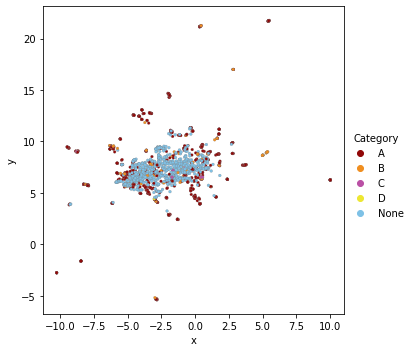

In [34]:
cdict = {
'None': '#7ec1e6',
'A': '#910707',
'B': '#f08e1f',
'C': '#ba50a5',
'D': '#ede732'
}

sns.relplot(
data=dfm_comb, x="x", y="y", hue="Category", edgecolor="grey",
s=8, palette = cdict, facet_kws={"despine": False}
)

In [35]:
df_comb.to_csv("data/scores/02 sim_scores_dim_reduced_glove.csv")

### II. Legal Word2Vec

##### Document embedding matrix (from SigmaLaw word2vec trained from legal corpus)

In [36]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

(52431, 200)

In [37]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [39]:
text_dfm = vectorizer.fit_transform(text_labels['text_clean'])
text_doc_matrix = doc_matrix_w2v(text_dfm)
text_doc_matrix.shape

(1533, 200)

In [40]:
defs_dfm = vectorizer.fit_transform(defs_grouped['text_clean'])
defs_doc_matrix = doc_matrix_w2v(defs_dfm)
defs_doc_matrix.shape

(4, 200)

Full sample

In [41]:
# get corpus vocabulary
text_dfm = vectorizer.fit_transform(text_labels_grouped['text_clean'])
words = set(vectorizer.get_feature_names_out())
text_vocab = list(words)

In [42]:
# get common features between vocab & w2v legal
common_features = []
for word in text_vocab:
    if word in w2v_law:
        common_features += [word]
len(common_features)

1387

In [43]:
# get embedding matrix of common features
embed_common=np.empty((0,200))
for word in words:
    if word in w2v_law:
        embed_common=np.vstack([embed_common, w2v_law[word]])
embed_common.shape

(1387, 200)

In [44]:
vocab_ids = [vectorizer.vocabulary_[x] for x in common_features] # vocab id of common features
text_doc_matrix = text_dfm[:,vocab_ids].dot(embed_common)
text_doc_matrix.shape

(1533, 200)

##### Cosine similarities

In [45]:
docs = []
for i in range(len(text_doc_matrix)):
    scores = []
    for j in range(len(defs_doc_matrix)):
        A = text_doc_matrix[i]
        B = defs_doc_matrix[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [46]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "D"])

In [47]:
scores_df

,A,B,C,D
0,0.655081,0.611224,0.613267,0.616344
1,0.639082,0.642908,0.636596,0.622064
2,0.725378,0.726920,0.692451,0.690617
3,0.732173,0.733428,0.727870,0.700281
4,0.732173,0.733428,0.727870,0.700281
...,...,...,...,...
1528,0.494828,0.494364,0.525171,0.568176
1529,0.702454,0.639906,0.657684,0.545291
1530,0.557336,0.537643,0.553452,0.492651
1531,0.649995,0.612506,0.633116,0.607105


In [50]:
text_scores_legalw2v = pd.merge(text_labels, scores_df, left_index=True, right_index=True)

In [51]:
text_scores_legalw2v.to_csv("data/scores/01 sim_scores_legalw2v_labeled.csv")

##### Dimensionality reduction

In [53]:
dfm_comb = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

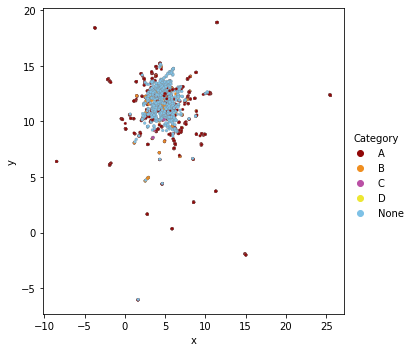

In [54]:
cdict = {
'None': '#7ec1e6',
'A': '#910707',
'B': '#f08e1f',
'C': '#ba50a5',
'D': '#ede732'
}

sns.relplot(
data=df_comb, x="x", y="y", hue="Category", edgecolor="grey",
s=8, palette = cdict, facet_kws={"despine": False}
)

In [55]:
df_comb.to_csv("data/scores/02 sim_scores_dim_reduced_legal.csv")